# Financial Time Series Volume Prediction — Complete Diagnostic Pipeline
This notebook walks through building, diagnosing, and improving an OLS-based volume prediction model, step-by-step. It covers multicollinearity, heteroskedasticity, autocorrelation, stationarity, and regularization.

Before running the regression make a plot of the target and check if it is stationary, if not take a log(return/difference) or regress it against something else such that there is cointegration. Testing if errors are stationary is the most important thing. Keep in mind that exogeneity not such big problem for prediction, but problem for inference. Homoskedasticity is not that important.

A bit more exploration before fitting regression. Nice to have plot of the target. Test significance of lags. Have more attention to features and less to test statistics. Make a few scatter plots of target against different xs. If relation not linear, transform that feature. 

The most important thing is to build features that are early warning signals. When do you expect lot of volume? Different types of volatility features. Maybe a trend indicator. At certain times you usually have more volumes (beginning/end of the day).

Few scatter plots more
Not so many stat tests -> but do check residuals 
Include correlation and pacf plots
We could also do PCA to fix condition number if we do not want to through away features
Remove tests, too many


In [58]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
plt.style.use('seaborn-v0_8-whitegrid')
pd.options.display.float_format = '{:,.4f}'.format

Maybe do not use vol.pct_cahnge()

In [54]:
# --- Data ---
df = yf.download('AAPL', start='2020-01-01', end='2024-01-01')
if isinstance(df.columns, pd.MultiIndex):
    df.columns = [c[0] for c in df.columns]
df['Return_1d'] = df['Close'].pct_change()
df['Range'] = (df['High'] - df['Low']) / df['Close']
df['MA_10'] = df['Close'].rolling(10).mean()
df['MA_50'] = df['Close'].rolling(50).mean()
df['MA_Ratio'] = df['MA_10'] / df['MA_50']
df['Volatility_10d'] = df['Return_1d'].rolling(10).std()
df['Volume_Change'] = df['Volume'].pct_change()
df['DayOfWeek'] = df.index.dayofweek
df['Month'] = df.index.month
df['y'] = df['Volume'].shift(-1)
df = df.dropna()

df

C:\Users\fgili\AppData\Local\Temp\ipykernel_14772\1420744362.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('AAPL', start='2020-01-01', end='2024-01-01')
[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume,Return_1d,Range,MA_10,MA_50,MA_Ratio,Volatility_10d,Volume_Change,DayOfWeek,Month,y
Date,,,,,,,,,,,,,,,
2020-03-13,67.2928,67.7649,61.2358,64.1263,370732000,0.1198,0.0970,68.4127,73.9420,0.9252,0.0743,-0.1141,4,3,"322,423,600.0000"
2020-03-16,58.6358,62.7198,58.1007,58.5728,322423600,-0.1286,0.0788,67.0425,73.6639,0.9101,0.0778,-0.1303,0,3,"324,056,000.0000"
2020-03-17,61.2140,62.3639,57.7134,59.9188,324056000,0.0440,0.0760,66.1598,73.4515,0.9007,0.0799,0.0051,1,3,"300,233,600.0000"
2020-03-18,59.7155,60.5216,57.4035,58.0451,300233600,-0.0245,0.0522,64.8024,73.1977,0.8853,0.0774,-0.0735,2,3,"271,857,200.0000"
2020-03-19,59.2579,61.2091,58.7326,59.8898,271857200,-0.0077,0.0418,63.6370,72.9416,0.8724,0.0773,-0.0945,3,3,"401,693,200.0000"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-21,193.0456,195.4255,191.8755,194.4537,46482500,-0.0008,0.0184,194.3129,183.4905,1.0590,0.0094,-0.1103,3,12,"37,149,600.0000"
2023-12-22,191.9747,193.7695,191.3500,193.5414,37149600,-0.0055,0.0126,194.1037,183.7508,1.0563,0.0091,-0.2008,4,12,"28,919,300.0000"
2023-12-26,191.4293,192.2623,191.2112,191.9846,28919300,-0.0028,0.0055,194.0908,184.0371,1.0546,0.0082,-0.2215,1,12,"48,087,700.0000"


In [37]:
features = ['Open', 'High', 'Low', 'Close', 'Return_1d', 'Range', 'MA_Ratio', 'Volatility_10d', 'Volume_Change', 'DayOfWeek', 'Month']
X = df[features]
y = df['y']
split_date = '2023-01-01'
X_train, X_test = X.loc[:split_date], X.loc[split_date:]
y_train, y_test = y.loc[:split_date], y.loc[split_date:]
X_train_ols = sm.add_constant(X_train)
X_test_ols = sm.add_constant(X_test, has_constant='add')
ols = sm.OLS(y_train, X_train_ols).fit()
print(ols.summary())

y_pred_train = ols.fittedvalues
y_pred_train = ols.predict(X_train_ols)
y_pred_test  = ols.predict(X_test_ols)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.568
Model:                            OLS   Adj. R-squared:                  0.561
Method:                 Least Squares   F-statistic:                     82.92
Date:                Sat, 08 Nov 2025   Prob (F-statistic):          1.30e-118
Time:                        17:11:15   Log-Likelihood:                -13240.
No. Observations:                 707   AIC:                         2.650e+04
Df Residuals:                     695   BIC:                         2.656e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -1.053e+08   2.58e+07     -4.

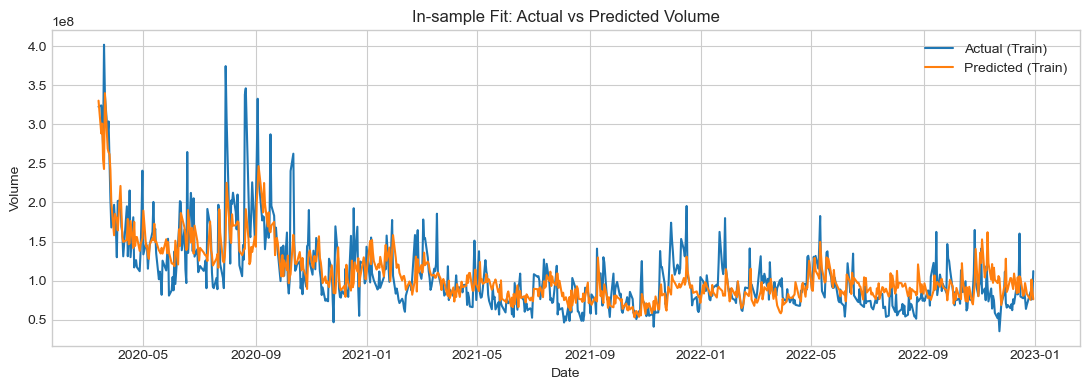

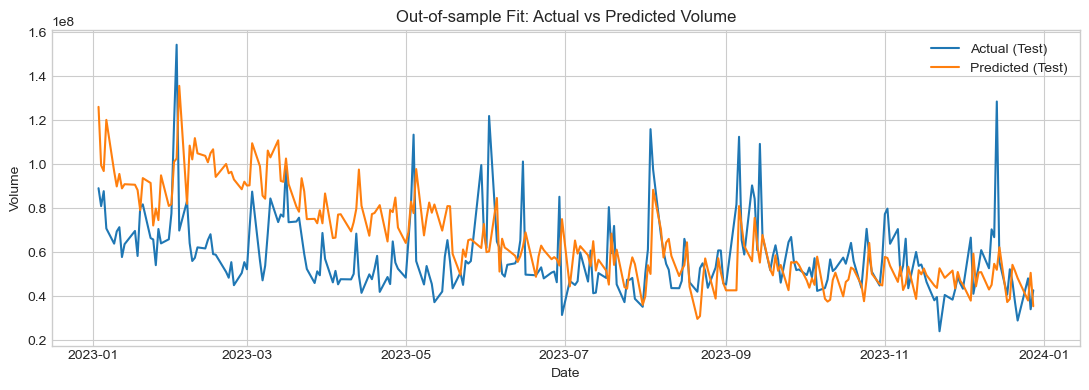

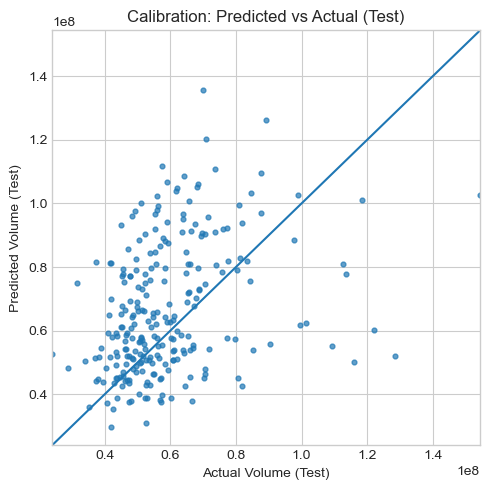

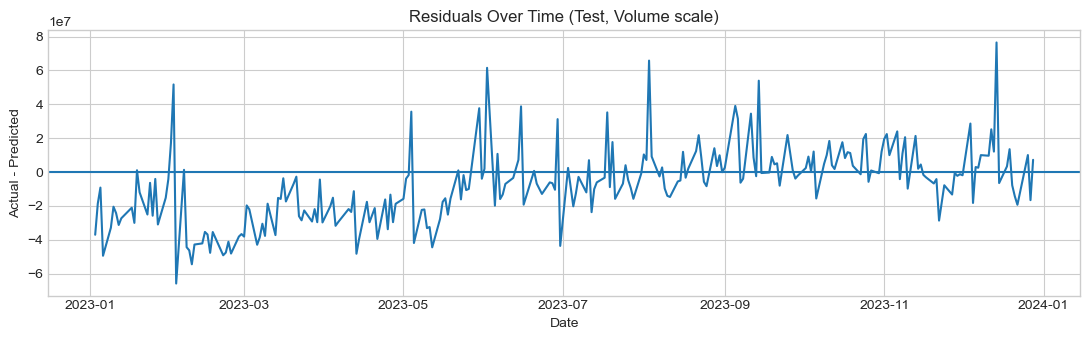

In [38]:
plt.figure(figsize=(11,4))
plt.plot(y_train.index, y_train.values, label='Actual (Train)')
plt.plot(y_train.index, y_pred_train.values, label='Predicted (Train)')
plt.title('In-sample Fit: Actual vs Predicted Volume')
plt.xlabel('Date'); plt.ylabel('Volume'); plt.legend()
plt.tight_layout(); plt.show()


plt.figure(figsize=(11,4))
plt.plot(y_test.index, y_test.values, label='Actual (Test)')
plt.plot(y_test.index, y_pred_test.values, label='Predicted (Test)')
plt.title('Out-of-sample Fit: Actual vs Predicted Volume')
plt.xlabel('Date'); plt.ylabel('Volume'); plt.legend()
plt.tight_layout(); plt.show()


plt.figure(figsize=(5,5))
plt.scatter(y_test.values, y_pred_test.values, s=12, alpha=0.7)
lims = [min(y_test.min(), y_pred_test.min()),
        max(y_test.max(), y_pred_test.max())]
plt.plot(lims, lims)  # 45-degree line
plt.xlim(lims); plt.ylim(lims)
plt.xlabel('Actual Volume (Test)'); plt.ylabel('Predicted Volume (Test)')
plt.title('Calibration: Predicted vs Actual (Test)')
plt.tight_layout(); plt.show()


resid_test = y_test - y_pred_test

plt.figure(figsize=(11,3.5))
plt.plot(resid_test.index, resid_test.values)
plt.axhline(0.0)
plt.title('Residuals Over Time (Test, Volume scale)')
plt.xlabel('Date'); plt.ylabel('Actual - Predicted')
plt.tight_layout(); plt.show()

## Step 1: Multicollinearity

In [39]:
vif = pd.DataFrame()
vif['Feature'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
display(vif)

,Feature,VIF
0,Open,"23,636.5593"
1,High,"116,787.1583"
2,Low,"109,306.5685"
3,Close,"28,222.3458"
4,Return_1d,2.5808
5,Range,79.5738
6,MA_Ratio,65.3306
7,Volatility_10d,10.2182
8,Volume_Change,1.2631
9,DayOfWeek,3.1324


In [40]:
reduced_features = ['Return_1d', 'Range', 'MA_Ratio', 'Volatility_10d', 'Volume_Change', 'DayOfWeek', 'Month']
Xr = df[reduced_features]
X_train_r, X_test_r = Xr.loc[:split_date], Xr.loc[split_date:]
y_train_r, y_test_r = y.loc[:split_date], y.loc[split_date:]
ols_r = sm.OLS(y_train_r, sm.add_constant(X_train_r)).fit()
print(ols_r.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.476
Model:                            OLS   Adj. R-squared:                  0.470
Method:                 Least Squares   F-statistic:                     90.56
Date:                Sat, 08 Nov 2025   Prob (F-statistic):           1.16e-93
Time:                        17:12:26   Log-Likelihood:                -13308.
No. Observations:                 707   AIC:                         2.663e+04
Df Residuals:                     699   BIC:                         2.667e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -2.196e+08   2.38e+07     -9.

In [41]:
vif_r = pd.DataFrame()
vif_r['Feature_r'] = X_train_r.columns
vif_r['VIF_r'] = [variance_inflation_factor(X_train_r.values, i) for i in range(X_train_r.shape[1])]
display(vif_r)

,Feature_r,VIF_r
0,Return_1d,1.0276
1,Range,8.4754
2,MA_Ratio,12.1091
3,Volatility_10d,7.1809
4,Volume_Change,1.2412
5,DayOfWeek,3.1099
6,Month,5.4902


## Step 2: Heteroskedasticity OPTIONAL

In [42]:
bp_test = het_breuschpagan(ols_r.resid, ols_r.model.exog)
labels = ['LM stat', 'LM p-value', 'F stat', 'F p-value']
print(dict(zip(labels, bp_test)))
ols_r_robust = sm.OLS(y_train_r, sm.add_constant(X_train_r)).fit(cov_type='HC3')
print(ols_r_robust.summary())

{'LM stat': 55.72890345183958, 'LM p-value': 1.0689115534542625e-09, 'F stat': 8.544719860527001, 'F p-value': 4.5524193236276815e-10}
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.476
Model:                            OLS   Adj. R-squared:                  0.470
Method:                 Least Squares   F-statistic:                     53.81
Date:                Sat, 08 Nov 2025   Prob (F-statistic):           1.93e-61
Time:                        17:12:42   Log-Likelihood:                -13308.
No. Observations:                 707   AIC:                         2.663e+04
Df Residuals:                     699   BIC:                         2.667e+04
Df Model:                           7                                         
Covariance Type:                  HC3                                         
                     coef    std err          z      P>|z|      [0.025     

## Step 3: Autocorrelation 

In [43]:
dw = durbin_watson(ols_r.resid)
print('Durbin-Watson:', dw)
df['LagVol1'] = df['Volume'].shift(1)
df['LagVol2'] = df['Volume'].shift(2)
lag_features = reduced_features + ['LagVol1', 'LagVol2']
df = df.dropna()
X_l = df[lag_features]
y_l = df['y']
ols_l = sm.OLS(y_l, sm.add_constant(X_l)).fit()
print(ols_l.summary())

Durbin-Watson: 1.3224750665684994
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     170.9
Date:                Sat, 08 Nov 2025   Prob (F-statistic):          2.35e-191
Time:                        17:12:56   Log-Likelihood:                -17760.
No. Observations:                 954   AIC:                         3.554e+04
Df Residuals:                     944   BIC:                         3.559e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const     

## Step 4: Stationarity CHANGE IT TO STATIONARITY OF RESIDUALS

if residuals not stationary you might have to transform the y. If residuals are not stationary you can to rolling regression. You might have a rolling model because you might have local stationarity

In [44]:
result = adfuller(df['Volume'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
df['LogVolume'] = np.log(df['Volume'])
df['y_log'] = np.log(df['Volume'].shift(-1))
df['LagLogVol1'] = df['LogVolume'].shift(1)
df['LagLogVol2'] = df['LogVolume'].shift(2)
df = df.dropna()
features_stationary = ['Return_1d', 'Range', 'MA_Ratio', 'Volatility_10d', 'Volume_Change', 'LagLogVol1', 'LagLogVol2', 'DayOfWeek', 'Month']
X_stat = df[features_stationary]
y_stat = df['y_log']
ols_s = sm.OLS(y_stat, sm.add_constant(X_stat)).fit()
print(ols_s.summary())

ADF Statistic: -4.957840398623758
p-value: 2.6876347298933157e-05
                            OLS Regression Results                            
Dep. Variable:                  y_log   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.665
Method:                 Least Squares   F-statistic:                     210.6
Date:                Sat, 08 Nov 2025   Prob (F-statistic):          1.68e-218
Time:                        17:13:04   Log-Likelihood:                -12.592
No. Observations:                 951   AIC:                             45.18
Df Residuals:                     941   BIC:                             93.76
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

## Step 5: Normality of Residuals

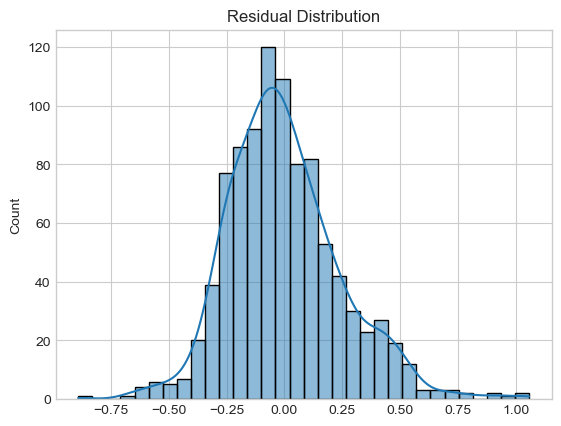

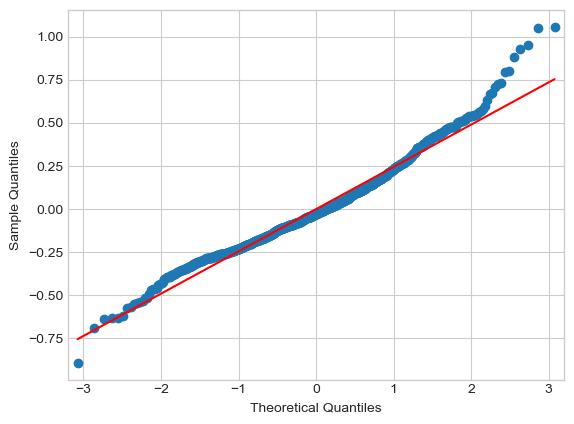

JB: stat=122.639, p=2.34e-27


In [46]:
sns.histplot(ols_s.resid, kde=True)
plt.title('Residual Distribution')
plt.show()
sm.qqplot(ols_s.resid, line='s')
plt.show()
from statsmodels.stats.stattools import jarque_bera

# Jarque–Bera
jb_stat, jb_pvalue, skew, kurt = jarque_bera( ols_s.resid)
print(f"JB: stat={jb_stat:.3f}, p={jb_pvalue:.3g}")

In [51]:
from xgboost import XGBRegressor
import numpy as np
import pandas as pd
import statsmodels.api as sm

# 1) Fit XGB on OLS residuals (log scale)
mask_tr = X_stat.index < split_date
ols_log_pred = ols_s.predict(sm.add_constant(X_stat))
resid = y_stat - ols_log_pred

#xgb = XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=4,
#                   subsample=0.8, colsample_bytree=0.8, random_state=0) # this is overfitting
xgb = XGBRegressor(
    objective="reg:squarederror",
    n_estimators=400,        # fewer trees
    learning_rate=0.03,      # slower learning
    max_depth=3,             # shallower trees
    min_child_weight=10,     # require more data per split
    gamma=1.0,               # split only if loss improves enough
    subsample=0.6,           # row sampling
    colsample_bytree=0.6,    # feature sampling per tree
    colsample_bynode=0.8,    # feature sampling per split
    reg_lambda=2.0,          # L2
    reg_alpha=0.1,           # L1
    random_state=0,
    tree_method="hist"
)
xgb.fit(X_stat[mask_tr], resid[mask_tr],
        eval_set=[(X_stat[~mask_tr], resid[~mask_tr])],
        verbose=False)

# 2) Combine OLS + XGB on full set (still log of Volume_{t+1})
yhat_log_all = pd.Series(ols_log_pred + xgb.predict(X_stat),
                         index=X_stat.index, name='yhat_log')

# 3) Back-transform to Volume scale and align target as Volume.shift(-1)
yhat_all = np.exp(yhat_log_all)  # predicted Volume_{t+1}
y_actual_all = df.loc[X_stat.index, 'Volume'].shift(-1)

# 4) Train/Test split for plotting
y_pred_train = yhat_all.loc[:split_date]
y_pred_test  = yhat_all.loc[split_date:]
y_train = y_actual_all.loc[:split_date]
y_test  = y_actual_all.loc[split_date:]


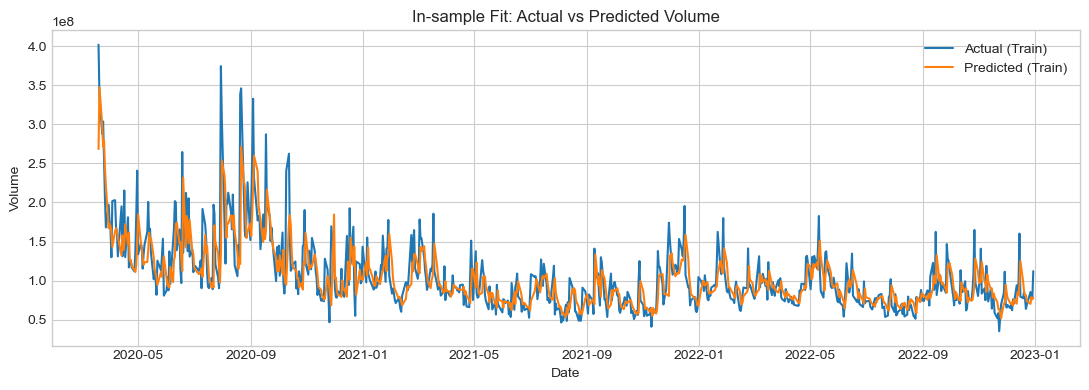

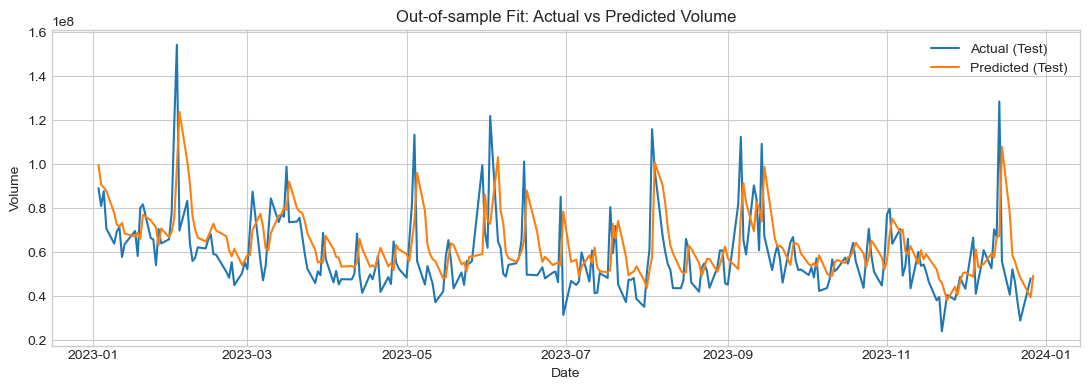

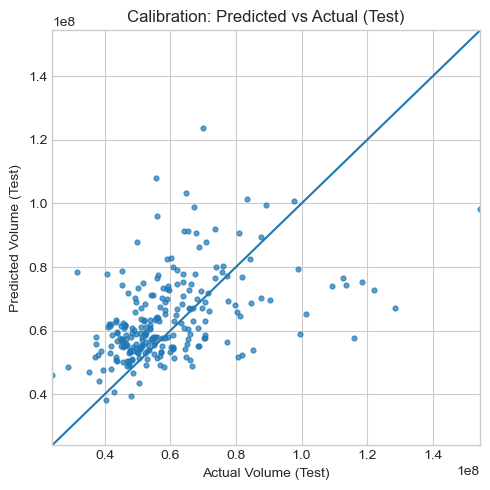

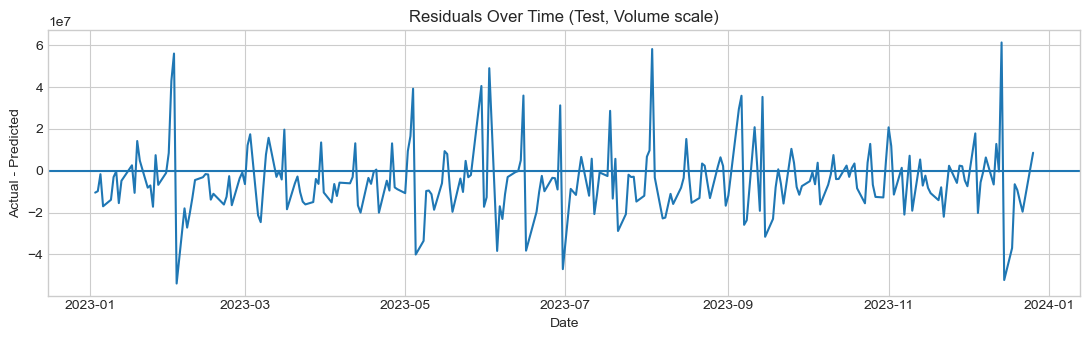

In [52]:
plt.figure(figsize=(11,4))
plt.plot(y_train.index, y_train.values, label='Actual (Train)')
plt.plot(y_train.index, y_pred_train.values, label='Predicted (Train)')
plt.title('In-sample Fit: Actual vs Predicted Volume')
plt.xlabel('Date'); plt.ylabel('Volume'); plt.legend()
plt.tight_layout(); plt.show()


plt.figure(figsize=(11,4))
plt.plot(y_test.index, y_test.values, label='Actual (Test)')
plt.plot(y_test.index, y_pred_test.values, label='Predicted (Test)')
plt.title('Out-of-sample Fit: Actual vs Predicted Volume')
plt.xlabel('Date'); plt.ylabel('Volume'); plt.legend()
plt.tight_layout(); plt.show()


plt.figure(figsize=(5,5))
plt.scatter(y_test.values, y_pred_test.values, s=12, alpha=0.7)
lims = [min(y_test.min(), y_pred_test.min()),
        max(y_test.max(), y_pred_test.max())]
plt.plot(lims, lims)  # 45-degree line
plt.xlim(lims); plt.ylim(lims)
plt.xlabel('Actual Volume (Test)'); plt.ylabel('Predicted Volume (Test)')
plt.title('Calibration: Predicted vs Actual (Test)')
plt.tight_layout(); plt.show()


resid_test = y_test - y_pred_test

plt.figure(figsize=(11,3.5))
plt.plot(resid_test.index, resid_test.values)
plt.axhline(0.0)
plt.title('Residuals Over Time (Test, Volume scale)')
plt.xlabel('Date'); plt.ylabel('Actual - Predicted')
plt.tight_layout(); plt.show()

## Step 6: Regularization Comparison

In [14]:
split_date = '2023-01-01'
X_train_s, X_test_s = X_stat.loc[:split_date], X_stat.loc[split_date:]
y_train_s, y_test_s = y_stat.loc[:split_date], y_stat.loc[split_date:]
scaler = StandardScaler()
ridge = make_pipeline(scaler, RidgeCV(alphas=np.logspace(-2,3,20)))
lasso = make_pipeline(scaler, LassoCV(alphas=np.logspace(-3,1,20), max_iter=10000))
enet = make_pipeline(scaler, ElasticNetCV(l1_ratio=[.2,.5,.8], n_alphas=50, max_iter=10000))
ridge.fit(X_train_s, y_train_s)
lasso.fit(X_train_s, y_train_s)
enet.fit(X_train_s, y_train_s)
for name, model in {'Ridge': ridge, 'Lasso': lasso, 'ElasticNet': enet}.items():
    y_pred = model.predict(X_test_s)
    print(name, '| R2:', r2_score(y_test_s, y_pred), '| MAE:', mean_absolute_error(y_test_s, y_pred))

Ridge | R2: -0.04831282572052609 | MAE: 0.2172349633075709
Lasso | R2: -0.039779560050645424 | MAE: 0.21577731827704089
ElasticNet | R2: -0.0418455466369394 | MAE: 0.2160799500056273


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score

# --- Pick a split date (same as earlier) ---
split_date = '2023-01-01'

# --- Train/Test split using the stationary feature set ---
X_train_s, X_test_s = X_stat.loc[:split_date], X_stat.loc[split_date:]
y_train_s, y_test_s = y_stat.loc[:split_date], y_stat.loc[split_date:]

# --- Fit OLS on TRAIN only ---
X_train_s_ols = sm.add_constant(X_train_s)
X_test_s_ols  = sm.add_constant(X_test_s, has_constant='add')

ols_train = sm.OLS(y_train_s, X_train_s_ols).fit()
print(ols_train.summary())

# --- Predict (still in log-volume space) ---
y_pred_train_log = ols_train.predict(X_train_s_ols)
y_pred_test_log  = ols_train.predict(X_test_s_ols)

# --- Back-transform to volume space for interpretability ---
y_train_vol      = np.exp(y_train_s)
y_test_vol       = np.exp(y_test_s)
y_pred_train_vol = np.exp(y_pred_train_log)
y_pred_test_vol  = np.exp(y_pred_test_log)

# --- Simple metrics ---
print("\nIn-sample (TRAIN)")
print("MAE:", f"{mean_absolute_error(y_train_vol, y_pred_train_vol):,.0f}")
print("R^2:", f"{r2_score(y_train_vol, y_pred_train_vol):.3f}")

print("\nOut-of-sample (TEST)")
print("MAE:", f"{mean_absolute_error(y_test_vol, y_pred_test_vol):,.0f}")
print("R^2:", f"{r2_score(y_test_vol, y_pred_test_vol):.3f}")


                            OLS Regression Results                            
Dep. Variable:                  y_log   R-squared:                       0.587
Model:                            OLS   Adj. R-squared:                  0.582
Method:                 Least Squares   F-statistic:                     109.4
Date:                Sat, 08 Nov 2025   Prob (F-statistic):          9.01e-127
Time:                        10:49:25   Log-Likelihood:                -3.4303
No. Observations:                 703   AIC:                             26.86
Df Residuals:                     693   BIC:                             72.41
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              4.7556      0.657      7.

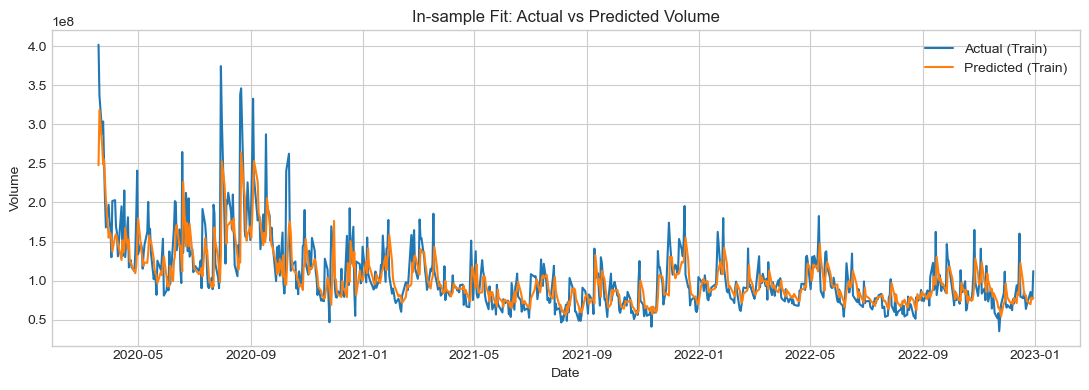

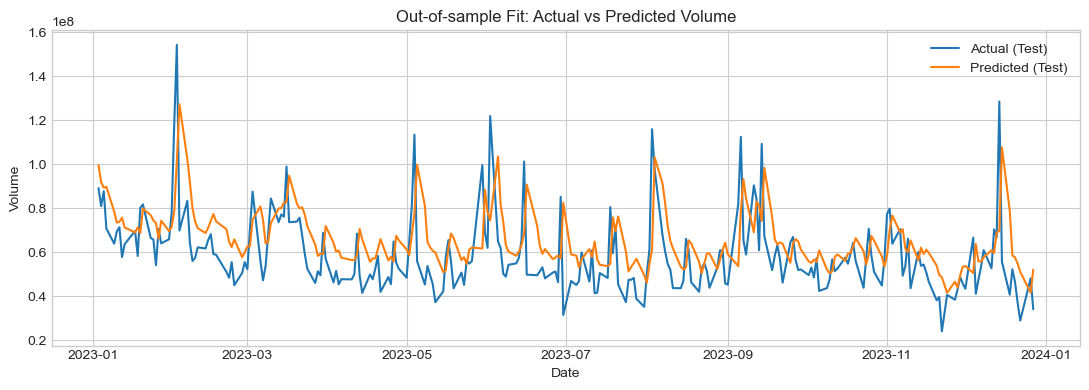

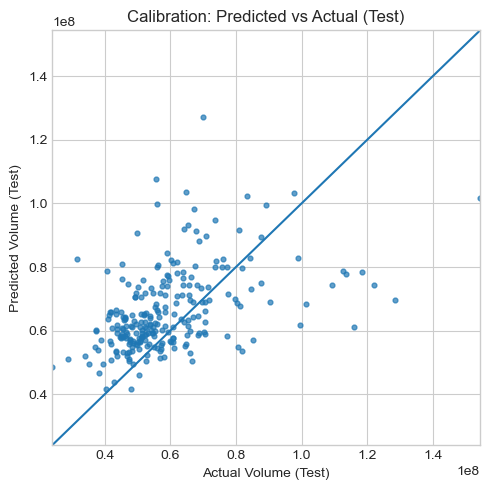

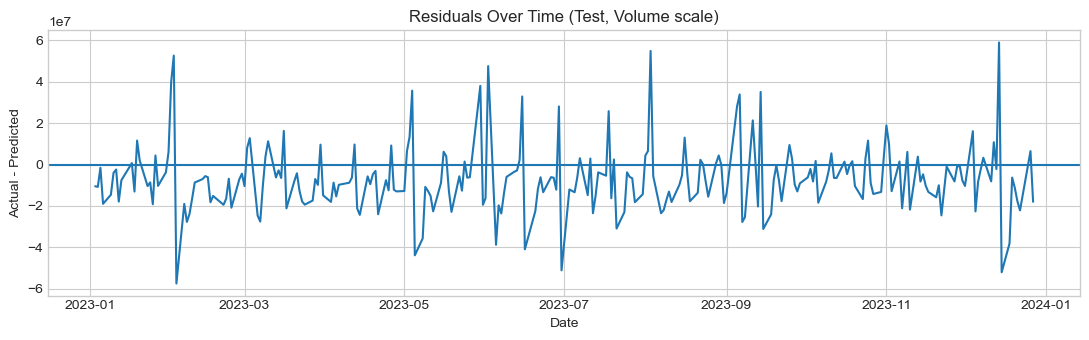

In [21]:
plt.figure(figsize=(11,4))
plt.plot(y_train_vol.index, y_train_vol.values, label='Actual (Train)')
plt.plot(y_train_vol.index, y_pred_train_vol.values, label='Predicted (Train)')
plt.title('In-sample Fit: Actual vs Predicted Volume')
plt.xlabel('Date'); plt.ylabel('Volume'); plt.legend()
plt.tight_layout(); plt.show()


plt.figure(figsize=(11,4))
plt.plot(y_test_vol.index, y_test_vol.values, label='Actual (Test)')
plt.plot(y_test_vol.index, y_pred_test_vol.values, label='Predicted (Test)')
plt.title('Out-of-sample Fit: Actual vs Predicted Volume')
plt.xlabel('Date'); plt.ylabel('Volume'); plt.legend()
plt.tight_layout(); plt.show()


plt.figure(figsize=(5,5))
plt.scatter(y_test_vol.values, y_pred_test_vol.values, s=12, alpha=0.7)
lims = [min(y_test_vol.min(), y_pred_test_vol.min()),
        max(y_test_vol.max(), y_pred_test_vol.max())]
plt.plot(lims, lims)  # 45-degree line
plt.xlim(lims); plt.ylim(lims)
plt.xlabel('Actual Volume (Test)'); plt.ylabel('Predicted Volume (Test)')
plt.title('Calibration: Predicted vs Actual (Test)')
plt.tight_layout(); plt.show()


resid_test_vol = y_test_vol - y_pred_test_vol

plt.figure(figsize=(11,3.5))
plt.plot(resid_test_vol.index, resid_test_vol.values)
plt.axhline(0.0)
plt.title('Residuals Over Time (Test, Volume scale)')
plt.xlabel('Date'); plt.ylabel('Actual - Predicted')
plt.tight_layout(); plt.show()




=== Ridge ===
Train: MAE=20,812,716 | R^2=0.570
Test : MAE=13,682,309 | R^2=-0.020


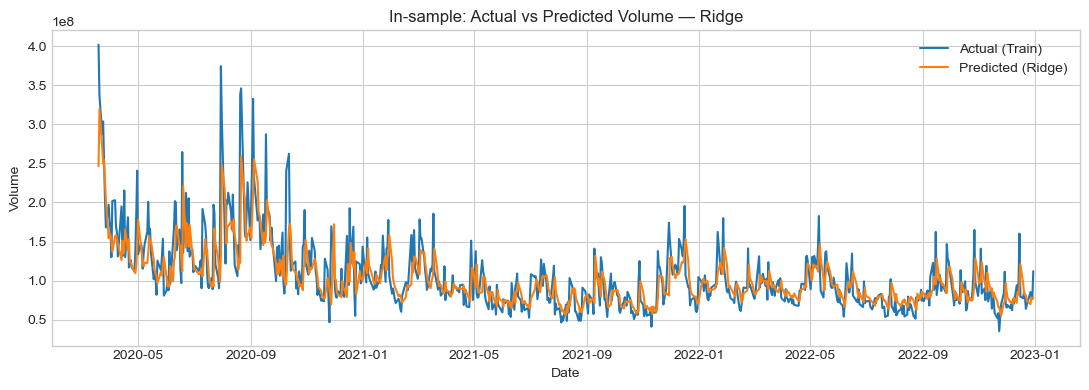

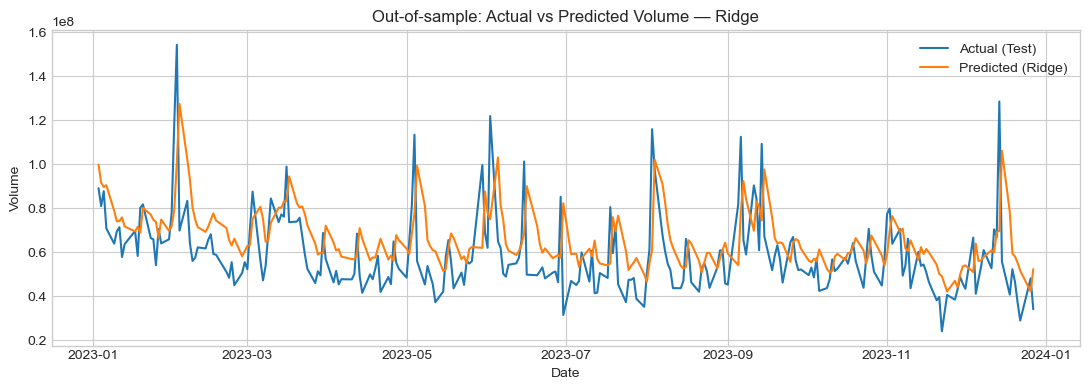

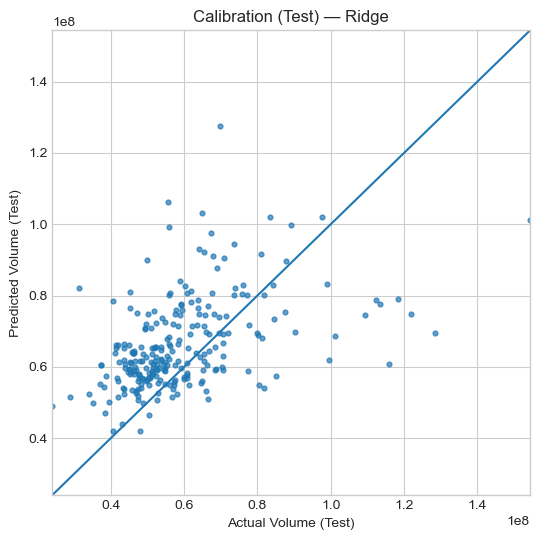

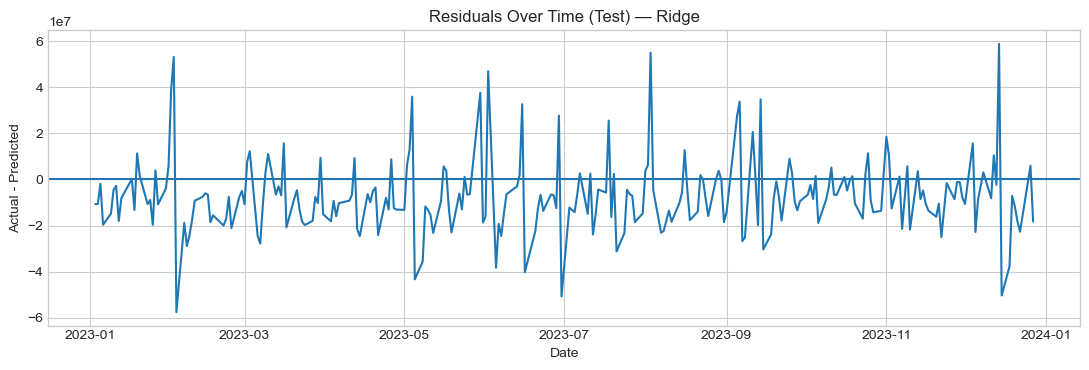


=== Lasso ===
Train: MAE=20,806,875 | R^2=0.569
Test : MAE=13,593,290 | R^2=-0.015


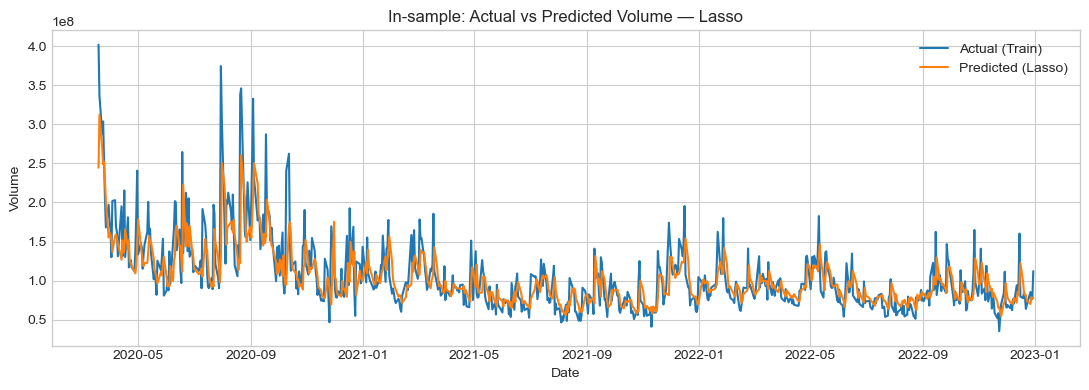

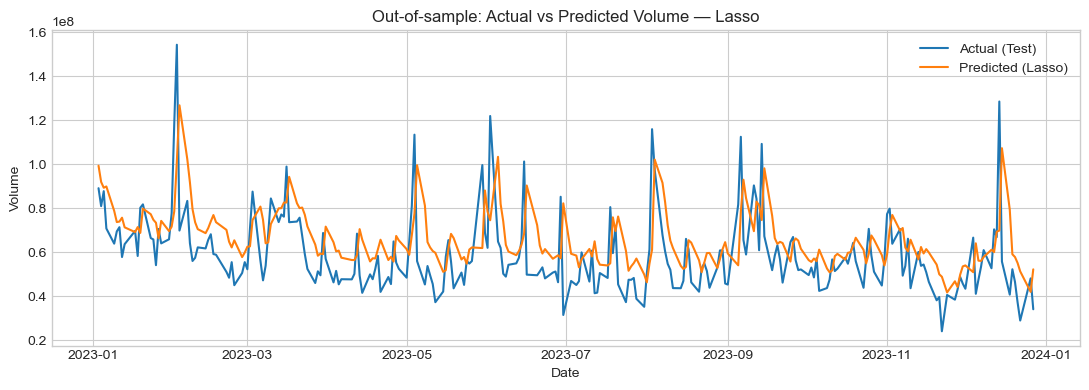

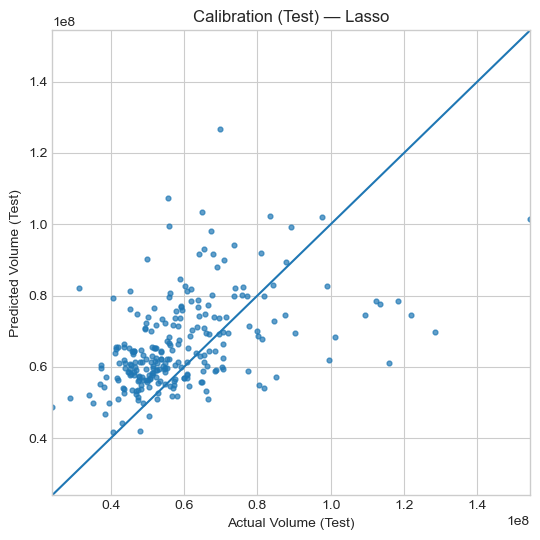

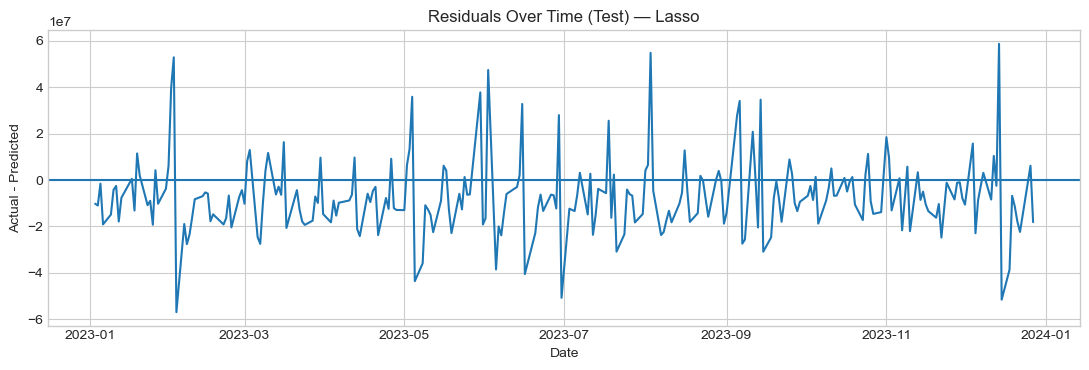


=== ElasticNet ===
Train: MAE=20,811,293 | R^2=0.569
Test : MAE=13,610,238 | R^2=-0.016


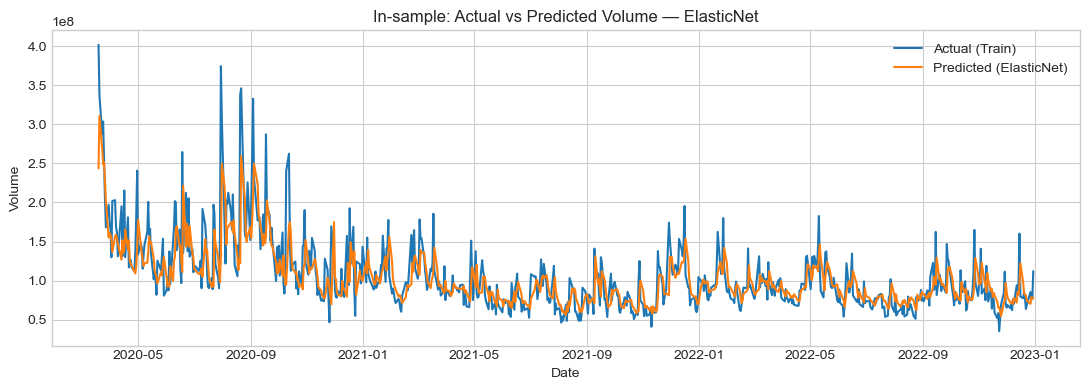

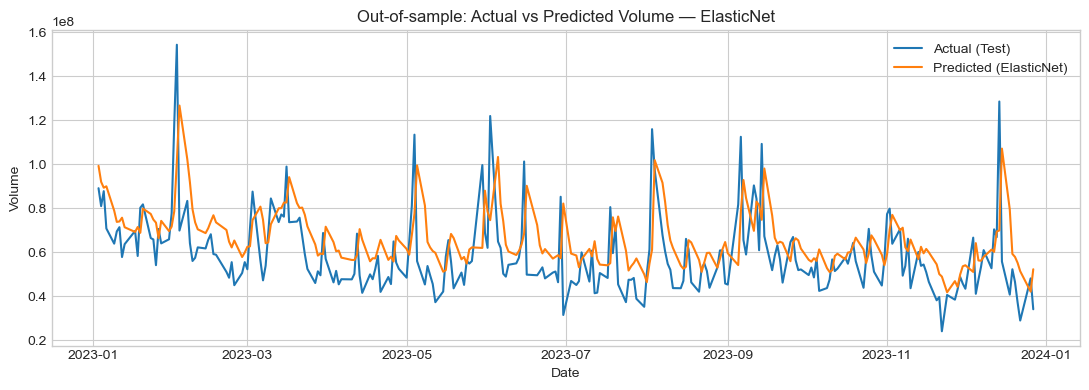

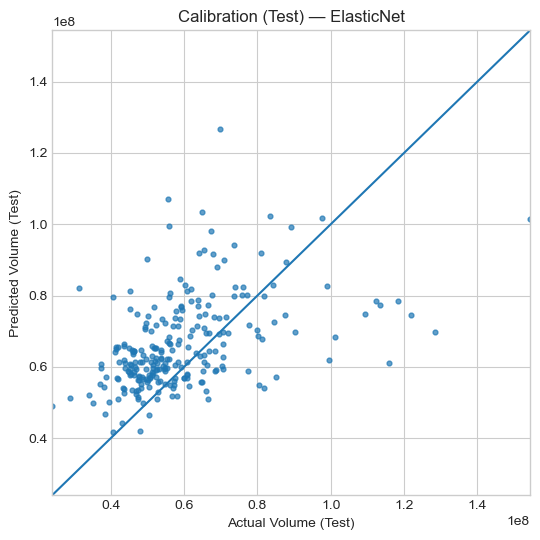

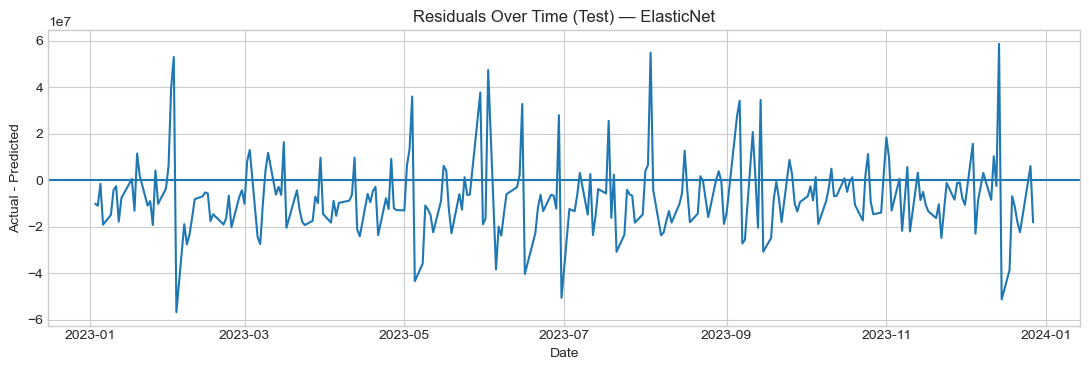

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score

# same split you used
split_date = '2023-01-01'
X_train_s, X_test_s = X_stat.loc[:split_date], X_stat.loc[split_date:]
y_train_s, y_test_s = y_stat.loc[:split_date], y_stat.loc[split_date:]

# back-transform to volume (truth)
y_train_vol = np.exp(y_train_s)
y_test_vol  = np.exp(y_test_s)

models = {
    "Ridge": ridge,
    "Lasso": lasso,
    "ElasticNet": enet
}

for name, model in models.items():
    # predictions (log space)
    y_pred_train_log = model.predict(X_train_s)
    y_pred_test_log  = model.predict(X_test_s)

    # back-transform and wrap as Series for aligned plotting
    y_pred_train_vol = pd.Series(np.exp(y_pred_train_log), index=y_train_vol.index)
    y_pred_test_vol  = pd.Series(np.exp(y_pred_test_log), index=y_test_vol.index)

    # metrics (on volume scale)
    mae_tr = mean_absolute_error(y_train_vol, y_pred_train_vol)
    r2_tr  = r2_score(y_train_vol, y_pred_train_vol)
    mae_te = mean_absolute_error(y_test_vol, y_pred_test_vol)
    r2_te  = r2_score(y_test_vol, y_pred_test_vol)

    print(f"\n=== {name} ===")
    print(f"Train: MAE={mae_tr:,.0f} | R^2={r2_tr:.3f}")
    print(f"Test : MAE={mae_te:,.0f} | R^2={r2_te:.3f}")

    # 1) In-sample line plot
    plt.figure(figsize=(11,4))
    plt.plot(y_train_vol.index, y_train_vol, label='Actual (Train)')
    plt.plot(y_pred_train_vol.index, y_pred_train_vol, label=f'Predicted ({name})')
    plt.title(f'In-sample: Actual vs Predicted Volume — {name}')
    plt.xlabel('Date'); plt.ylabel('Volume'); plt.legend(); plt.tight_layout(); plt.show()

    # 2) Out-of-sample line plot
    plt.figure(figsize=(11,4))
    plt.plot(y_test_vol.index, y_test_vol, label='Actual (Test)')
    plt.plot(y_pred_test_vol.index, y_pred_test_vol, label=f'Predicted ({name})')
    plt.title(f'Out-of-sample: Actual vs Predicted Volume — {name}')
    plt.xlabel('Date'); plt.ylabel('Volume'); plt.legend(); plt.tight_layout(); plt.show()

    # 3) Predicted vs Actual (TEST) scatter with 45° line
    plt.figure(figsize=(5.5,5.5))
    plt.scatter(y_test_vol, y_pred_test_vol, s=12, alpha=0.7)
    lims = [min(y_test_vol.min(), y_pred_test_vol.min()),
            max(y_test_vol.max(), y_pred_test_vol.max())]
    plt.plot(lims, lims)
    plt.xlim(lims); plt.ylim(lims)
    plt.xlabel('Actual Volume (Test)'); plt.ylabel('Predicted Volume (Test)')
    plt.title(f'Calibration (Test) — {name}')
    plt.tight_layout(); plt.show()

    # 4) Residuals over time (TEST)
    resid_test_vol = y_test_vol - y_pred_test_vol
    plt.figure(figsize=(11,3.8))
    plt.plot(resid_test_vol.index, resid_test_vol)
    plt.axhline(0.0)
    plt.title(f'Residuals Over Time (Test) — {name}')
    plt.xlabel('Date'); plt.ylabel('Actual - Predicted')
    plt.tight_layout(); plt.show()


C:\Users\fgili\AppData\Local\Temp\ipykernel_14772\90157537.py:26: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("AAPL", start="2020-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed


                            OLS Regression Results                            
Dep. Variable:                  y_log   R-squared:                       0.626
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                     49.62
Date:                Sat, 08 Nov 2025   Prob (F-statistic):          5.74e-129
Time:                        14:27:11   Log-Likelihood:                 15.849
No. Observations:                 707   AIC:                             16.30
Df Residuals:                     683   BIC:                             125.8
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              4.0065      0.738      5.

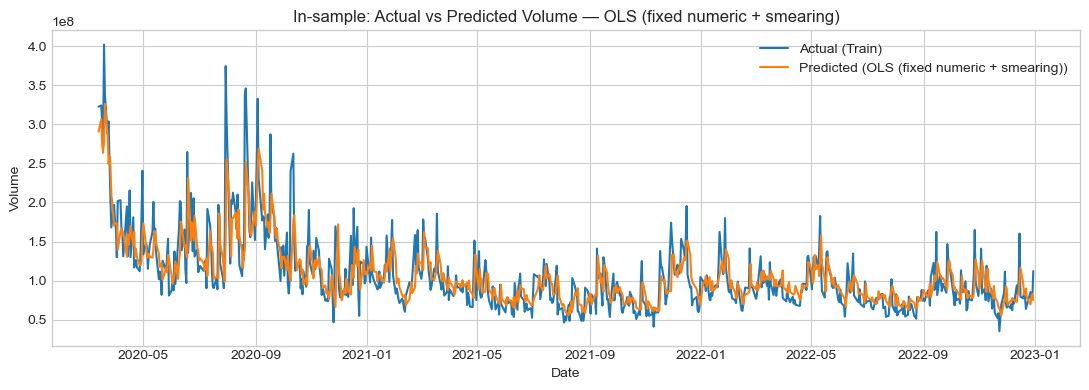

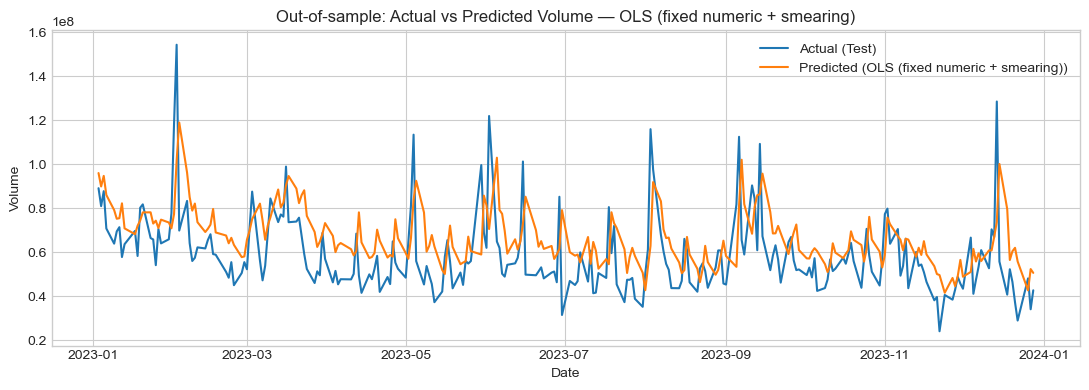

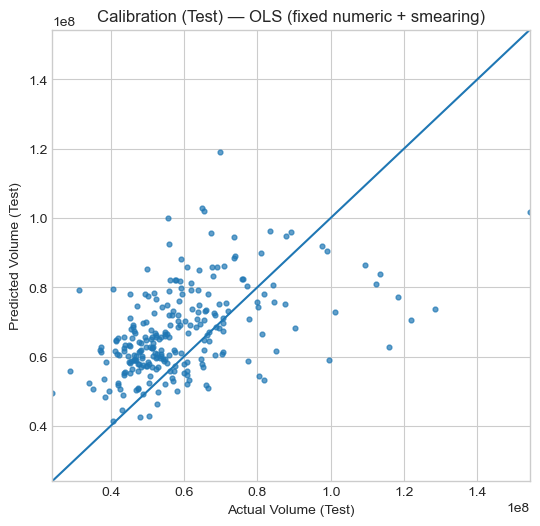

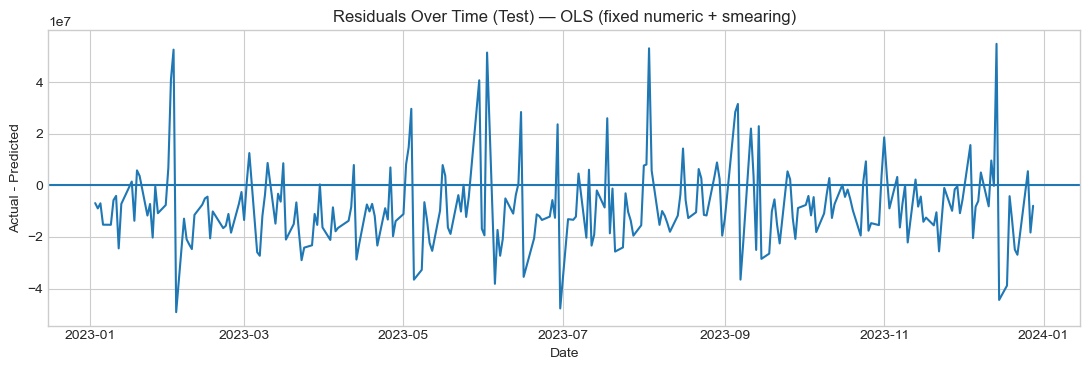

In [26]:
# ============================================================
# Unified pipeline with key fixes:
# - Stationary features + log target
# - One-hot calendar effects
# - Lagged log-volume (1,2,5)
# - Smearing bias correction on back-transform
# - OLS (improved) + ElasticNet (time-series CV)
# - In/Out-of-sample plots + metrics
# ============================================================

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import ElasticNetCV

# -----------------------------
# 1) Data & base features
# -----------------------------
df = yf.download("AAPL", start="2020-01-01", end="2024-01-01")
if isinstance(df.columns, pd.MultiIndex):
    df.columns = [c[0] for c in df.columns]

# Price/volatility features (stationary-ish)
df["Return_1d"]      = df["Close"].pct_change()
df["Range"]          = (df["High"] - df["Low"]) / df["Close"]
df["MA_10"]          = df["Close"].rolling(10).mean()
df["MA_50"]          = df["Close"].rolling(50).mean()
df["MA_Ratio"]       = df["MA_10"] / df["MA_50"]
df["Volatility_10d"] = df["Return_1d"].rolling(10).std()
df["Volume_Change"]  = df["Volume"].pct_change()

# Log-volume & lags
df["LogVolume"]   = np.log(df["Volume"])
for k in [1, 2, 5]:
    df[f"LogVol_lag{k}"] = df["LogVolume"].shift(k)

# Calendar as categoricals (to one-hot)
df["DayOfWeek"] = df.index.dayofweek.astype("category")
df["Month"]     = df.index.month.astype("category")

# Target: next-day log-volume
df["y_log"] = np.log(df["Volume"].shift(-1))

# Drop NA/inf
df = df.replace([np.inf, -np.inf], np.nan).dropna()

# -----------------------------
# 2) Design matrix with one-hot calendar
# -----------------------------
X = df[[
    "Return_1d", "Range", "MA_Ratio", "Volatility_10d",
    "Volume_Change", "LogVol_lag1", "LogVol_lag2", "LogVol_lag5",
    "DayOfWeek", "Month"
]]

# One-hot encode calendar (drop_first to avoid dummy trap)
X = pd.get_dummies(X, columns=["DayOfWeek", "Month"], drop_first=True)
y = df["y_log"]

# Align (just in case)
X, y = X.align(y, join="inner", axis=0)

# -----------------------------
# 3) Train / Test split
# -----------------------------
split_date = "2023-01-01"
X_tr, X_te = X.loc[:split_date], X.loc[split_date:]
y_tr, y_te = y.loc[:split_date], y.loc[split_date:]

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score
import statsmodels.api as sm

# ---------- helper: smearing-correct back-transform + plots ----------
def smear_factor(y_log_true, y_log_hat):
    resid = y_log_true - y_log_hat
    return float(np.mean(np.exp(resid)))

def eval_and_plot_ols(name, y_tr_log, y_te_log, yhat_tr_log, yhat_te_log):
    smear = smear_factor(y_tr_log, yhat_tr_log)

    y_tr_vol    = np.exp(y_tr_log)
    y_te_vol    = np.exp(y_te_log)
    yhat_tr_vol = np.exp(yhat_tr_log) * smear
    yhat_te_vol = np.exp(yhat_te_log) * smear

    print(f"\n=== {name} ===")
    print("Train MAE:", f"{mean_absolute_error(y_tr_vol, yhat_tr_vol):,.0f}",
          "| R^2:", f"{r2_score(y_tr_vol, yhat_tr_vol):.3f}")
    print("Test  MAE:", f"{mean_absolute_error(y_te_vol, yhat_te_vol):,.0f}",
          "| R^2:", f"{r2_score(y_te_vol, yhat_te_vol):.3f}")

    # In-sample
    plt.figure(figsize=(11,4))
    plt.plot(y_tr_vol.index, y_tr_vol, label="Actual (Train)")
    plt.plot(y_tr_vol.index, yhat_tr_vol, label=f"Predicted ({name})")
    plt.title(f"In-sample: Actual vs Predicted Volume — {name}")
    plt.xlabel("Date"); plt.ylabel("Volume"); plt.legend(); plt.tight_layout(); plt.show()

    # Out-of-sample
    plt.figure(figsize=(11,4))
    plt.plot(y_te_vol.index, y_te_vol, label="Actual (Test)")
    plt.plot(y_te_vol.index, yhat_te_vol, label=f"Predicted ({name})")
    plt.title(f"Out-of-sample: Actual vs Predicted Volume — {name}")
    plt.xlabel("Date"); plt.ylabel("Volume"); plt.legend(); plt.tight_layout(); plt.show()

    # Predicted vs Actual (TEST)
    plt.figure(figsize=(5.5,5.5))
    plt.scatter(y_te_vol, yhat_te_vol, s=12, alpha=0.7)
    lims = [min(y_te_vol.min(), yhat_te_vol.min()),
            max(y_te_vol.max(), yhat_te_vol.max())]
    plt.plot(lims, lims)
    plt.xlim(lims); plt.ylim(lims)
    plt.xlabel("Actual Volume (Test)"); plt.ylabel("Predicted Volume (Test)")
    plt.title(f"Calibration (Test) — {name}")
    plt.tight_layout(); plt.show()

    # Residuals over time (TEST)
    resid_test_vol = y_te_vol - yhat_te_vol
    plt.figure(figsize=(11,3.8))
    plt.plot(resid_test_vol.index, resid_test_vol)
    plt.axhline(0.0)
    plt.title(f"Residuals Over Time (Test) — {name}")
    plt.xlabel("Date"); plt.ylabel("Actual - Predicted")
    plt.tight_layout(); plt.show()

# ---------- FIXED OLS: force numeric dtypes and drop any coerced NaNs ----------
# Add constant and coerce to float (prevents "dtype=object" error)
X_tr_ols = sm.add_constant(X_tr, has_constant="add").apply(pd.to_numeric, errors="coerce").astype(float)
X_te_ols = sm.add_constant(X_te, has_constant="add").apply(pd.to_numeric, errors="coerce").astype(float)
y_tr_num = pd.to_numeric(y_tr, errors="coerce").astype(float)
y_te_num = pd.to_numeric(y_te, errors="coerce").astype(float)

# Drop rows with NaNs after coercion (usually none, but safe)
mask_tr = X_tr_ols.notna().all(axis=1) & y_tr_num.notna()
X_tr_ols, y_tr_num = X_tr_ols.loc[mask_tr], y_tr_num.loc[mask_tr]

mask_te = X_te_ols.notna().all(axis=1) & y_te_num.notna()
X_te_ols, y_te_num = X_te_ols.loc[mask_te], y_te_num.loc[mask_te]

# Fit OLS (optionally: cov_type="HC3" for robust SEs)
ols = sm.OLS(y_tr_num, X_tr_ols).fit()
print(ols.summary())

# Predictions in log space
yhat_tr_log = pd.Series(ols.predict(X_tr_ols), index=y_tr_num.index)
yhat_te_log = pd.Series(ols.predict(X_te_ols), index=y_te_num.index)

# Evaluate + plots with smearing correction
eval_and_plot_ols("OLS (fixed numeric + smearing)", y_tr_num, y_te_num, yhat_tr_log, yhat_te_log)
